In [2]:
import numpy as np
import pandas as pd
import zipfile

arys = []
with zipfile.ZipFile("GP_homework_data.zip") as zipf:
  for i in range(1, 101):
    h = pd.read_csv(zipf.open("OceanFlow/{}u.csv".format(i)), header=None).to_numpy().T
    v = pd.read_csv(zipf.open("OceanFlow/{}v.csv".format(i)), header=None).to_numpy().T
    arys.append(np.transpose(np.array([h, v], dtype=np.float32), [1, 2, 0]))
  mask = pd.read_csv(zipf.open("OceanFlow/mask.csv".format(i)), header=None).to_numpy().T[:,::-1]
data = np.array(arys)

### Problem 1 (a)

In [3]:
def argmin_nd(a):
  return np.unravel_index(np.argmin(a, axis=None), a.shape)

def argmax_nd(a):
  return np.unravel_index(np.argmax(a, axis=None), a.shape)

mag_variance = np.sqrt(np.square(data).sum(axis=3)).var(axis=0, ddof=0)
mag_variance[mag_variance == 0] = np.inf
p1_min_var_idxs = np.array(argmin_nd(mag_variance))
print("Location of minimum variance: {}".format(p1_min_var_idxs*3)) # Multiply by 3 to convert to kms

Location of minimum variance: [510 363]


### Problem 1 (b)

In [4]:
p1_max_xvelocity_idxs = np.array(argmax_nd(data[:,:,:,0]))
print("Location of maximum x-velocity: {}".format(p1_max_xvelocity_idxs*3)) # Multiply by 3 to convert to hrs and kms

Location of maximum x-velocity: [  84 1041  543]


### Problem 1 (c)

In [5]:
p1_whole_data_mean = data.mean(axis=(0, 1, 2))
print("Mean velocity over entire dataset: {}".format(p1_whole_data_mean))

Mean velocity over entire dataset: [-0.09359308 -0.03547521]


In [64]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel as W
from sklearn.preprocessing import StandardScaler
import pods
data = pods.datasets.olympic_marathon_men()
X = StandardScaler().fit_transform(data['X'])
y = data['Y']
# scikit-learn
model = GaussianProcessRegressor(C()*RBF(), n_restarts_optimizer=20, random_state=0)
model.fit(X, y)
print(model.kernel_)

# GPy
from GPy.models import GPRegression
from GPy.kern import RBF as GPyRBF
model = GPRegression(X, y, GPyRBF(1))
model['.*Gaussian_noise'] = 0
model['.*noise'].fix()
model.optimize_restarts(20, verbose=0)
print(model.kern)

data = pods.datasets.olympic_marathon_men()
X = StandardScaler().fit_transform(data['X'])
y = data['Y']
# scikit-learn
model = GaussianProcessRegressor(C()*RBF()+W(), n_restarts_optimizer=20, random_state=0) 
model.fit(X, y)
print(model.kernel_)

# GPy
from GPy.models import GPRegression
from GPy.kern import RBF as GPyRBF
model = GPRegression(X, y, GPyRBF(1))
model.optimize_restarts(20, verbose=0)
print(model.kern)

2.89**2 * RBF(length_scale=0.173)


 C:\Users\Sandipan.Dey\anaconda3\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:divide by zero encountered in log


  rbf.         |                value  |  constraints  |  priors
  variance     |    8.343280727316605  |      +ve      |        
  lengthscale  |  0.17317645415782507  |      +ve      |        
5.04**2 * RBF(length_scale=4.28) + WhiteKernel(noise_level=0.0485)
  rbf.         |               value  |  constraints  |  priors
  variance     |    25.3995066661936  |      +ve      |        
  lengthscale  |  4.2797670212128756  |      +ve      |        


In [65]:
5.04**2  #2.89**2  #model.noise_variance

25.401600000000002

In [12]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=10, shuffle=True)
kf.get_n_splits(X)

10

In [ ]:
length_scales = np.arange(1,6)
sigmas = np.arange(1,6)
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    for length_scale in length_scales:
        for sigma in sigmas:
            Σ22 = compute_sigma(x2, x2, σ, l)
            Σ12 = compute_sigma(x1, x2, σ, l)
            Σ21 = compute_sigma(x2, x1, σ, l)
            Σ11 = compute_sigma(x1, x1, σ, l)
            μ2 = np.mean(y2)
            μ1_2 = μ1 + Σ12@(np.linalg.solve(Σ22 + τ**2*np.eye(len(y2)), y2 - μ2)) 
            Σ1_2 = Σ11 - Σ12@(np.linalg.solve(Σ22 + τ**2*np.eye(len(y2)), Σ21)) 
            ll = compute_log_marginal_likelihood(y1, μ1, Σ1_2)

In [37]:
# LOO strategy Cross-Validation, not an efficient algorithm, just for illustration here
import itertools
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel
def cross_val_kernel(kernels, X, Y):
    performance = {}
    
    for kernel in kernels:
        print(kernel)
        likelihood = 0
        for i in range(Y.size):
            gp = GaussianProcessRegressor(kernel = kernel)
            X_train = np.delete(X, i, axis=0)
            Y_train = np.delete(Y, i, axis=0)
            gp.fit(X_train, Y_train)
            y_mean, y_std = gp.predict(X[[i], :], return_std = True)
            likelihood += -np.log(y_std[0]) - (Y[i] - y_mean[0])**2 / (2 * y_std[0]**2)
            
        performance[likelihood] = kernel
        print(kernel, likelihood)
        
    return performance

In [34]:
import numpy as np
parRange = [np.arange(1, 10, 5), np.arange(0.1, 1, 0.5), np.arange(0.1, 1, 0.5)]
kernels = [ConstantKernel(a, constant_value_bounds='fixed') * RBF(b, length_scale_bounds='fixed') 
           + WhiteKernel(c, noise_level_bounds='fixed') for a, b, c in list(itertools.product(*parRange))]
from sklearn.datasets import make_friedman2
X, Y = make_friedman2(n_samples=500, noise=0, random_state=0)
cross_val_kernel(kernels, X, Y)

1**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.1) -91561705.40083194
1**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.6) -62948773.58254206
1**2 * RBF(length_scale=0.6) + WhiteKernel(noise_level=0.1) -91550757.56358102
1**2 * RBF(length_scale=0.6) + WhiteKernel(noise_level=0.6) -62943588.94102016
2.45**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.1) -16511574.978851104
2.45**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.6) -15260752.029626755
2.45**2 * RBF(length_scale=0.6) + WhiteKernel(noise_level=0.1) -16509440.04902582
2.45**2 * RBF(length_scale=0.6) + WhiteKernel(noise_level=0.6) -15258927.389953077


{-91561705.40083194: 1**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.1),
 -62948773.58254206: 1**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.6),
 -91550757.56358102: 1**2 * RBF(length_scale=0.6) + WhiteKernel(noise_level=0.1),
 -62943588.94102016: 1**2 * RBF(length_scale=0.6) + WhiteKernel(noise_level=0.6),
 -16511574.978851104: 2.45**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.1),
 -15260752.029626755: 2.45**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.6),
 -16509440.04902582: 2.45**2 * RBF(length_scale=0.6) + WhiteKernel(noise_level=0.1),
 -15258927.389953077: 2.45**2 * RBF(length_scale=0.6) + WhiteKernel(noise_level=0.6)}

In [38]:
kernels = [ConstantKernel(a) * RBF(b) 
           + WhiteKernel(c) for a, b, c in list(itertools.product(*parRange))]

cross_val_kernel(kernels, X, Y)

1**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.1)


 C:\Users\Sandipan.Dey\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:437: ConvergenceWarning:The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
 C:\Users\Sandipan.Dey\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:437: ConvergenceWarning:The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
 C:\Users\Sandipan.Dey\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:437: ConvergenceWarning:The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
 C:\Users\Sandipan.Dey\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:437: Conver

 C:\Users\Sandipan.Dey\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:437: ConvergenceWarning:The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
 C:\Users\Sandipan.Dey\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:437: ConvergenceWarning:The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
 C:\Users\Sandipan.Dey\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:437: ConvergenceWarning:The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
 C:\Users\Sandipan.Dey\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:437: Conver

KeyboardInterrupt: 

In [49]:
kernels = [ConstantKernel(a, constant_value_bounds='fixed') * RBF(b, length_scale_bounds='fixed') 
           + WhiteKernel(c, noise_level_bounds='fixed') for a, b, c in list(itertools.product(*parRange))]
gp = GaussianProcessRegressor(kernel = kernels[0])
gp.fit(X, Y)
print(gp.kernel_)

1**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.1)


In [50]:
kernels = [ConstantKernel(a) * RBF(b) 
           + WhiteKernel(c) for a, b, c in list(itertools.product(*parRange))]
gp = GaussianProcessRegressor(kernel = kernels[0])
gp.fit(X, Y)
print(gp.kernel_)

316**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=1e+05)


 C:\Users\Sandipan.Dey\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:437: ConvergenceWarning:The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
 C:\Users\Sandipan.Dey\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:437: ConvergenceWarning:The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.


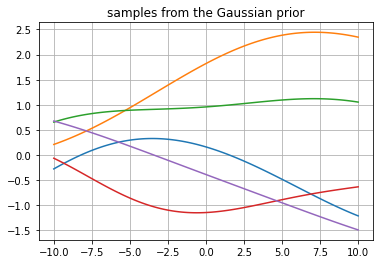

In [66]:
import numpy as np
import matplotlib.pyplot as plt 
from math import pi 
from scipy.spatial.distance import cdist
import scipy.stats as sts

x_prior = np.linspace(-10,10,101)
x_prior = x_prior.reshape(-1,1)
mu = np.zeros(x_prior.shape)

#defining the Kernel for the covariance function

def sec(a,b, length_scale , sigma) : 
    K = sigma * np.exp(-1/(2*length_scale) * cdist(a,b)**2)
    return K 

#defining the Gaussian Process prior

def GP(a , b, mu , kernel , length_scale, sigma , samples ) :
    f = np.random.multivariate_normal(mu.flatten(), kernel(a ,b , length_scale , sigma ) , samples)
    return f

prior = GP(x_prior ,x_prior, mu , sec , 100, 1 , 5)

plt.figure()
plt.grid()
plt.title('samples from the Gaussian prior')
plt.plot(x_prior , prior.T)
plt.show()

In [93]:
x_prior.shape, prior.shape

((101, 1), (5, 101))

In [79]:
def kernel(a,b, length_scale , sigma) : 
    K = sigma * np.exp(-1/(2*length_scale) * cdist(a,b)**2)
    return K 

x_train = np.array([-10,-8,5,-1,2])
x_train = x_train.reshape(-1,1)
def straight_line(m , x , c):
    y = 5*x + c
    return y
y_train = straight_line(5 , x_train , 0)

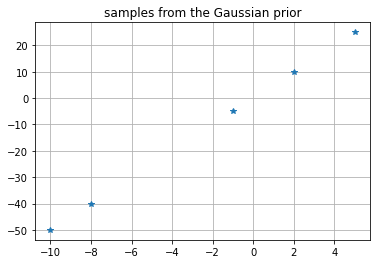

In [80]:
plt.figure()
plt.grid()
plt.title('samples from the Gaussian prior')
#plt.plot(x_prior , prior.T)
plt.plot(x_train, y_train, '*')
plt.show()

In [178]:
x_train = np.linspace(-10, 4, 10).reshape(-1,1)
y_train = np.random.random(10)

In [179]:
x_train.shape, y_train.shape

((10, 1), (10,))

In [185]:
x_p = np.linspace(-10, 4, 50).reshape(-1,1) #np.arange(-4,0).reshape(-1,1) #
K_train = kernel(x_train, x_train, length_scale=2, sigma=1)
K_pt = kernel(x_p, x_train, length_scale=2, sigma=1)
K_tp = kernel(x_train, x_p, length_scale=2, sigma=1)
K_prior = kernel(x_p, x_p, length_scale=2, sigma=1)

In [186]:
mean_function = np.dot(np.dot(K_pt ,np.linalg.inv(K_train)), y_train) 
covariance_function = K_prior - np.dot(np.dot(K_pt ,np.linalg.inv(K_train)) , K_tp) 
f = np.random.multivariate_normal(mean_function,covariance_function , 100)

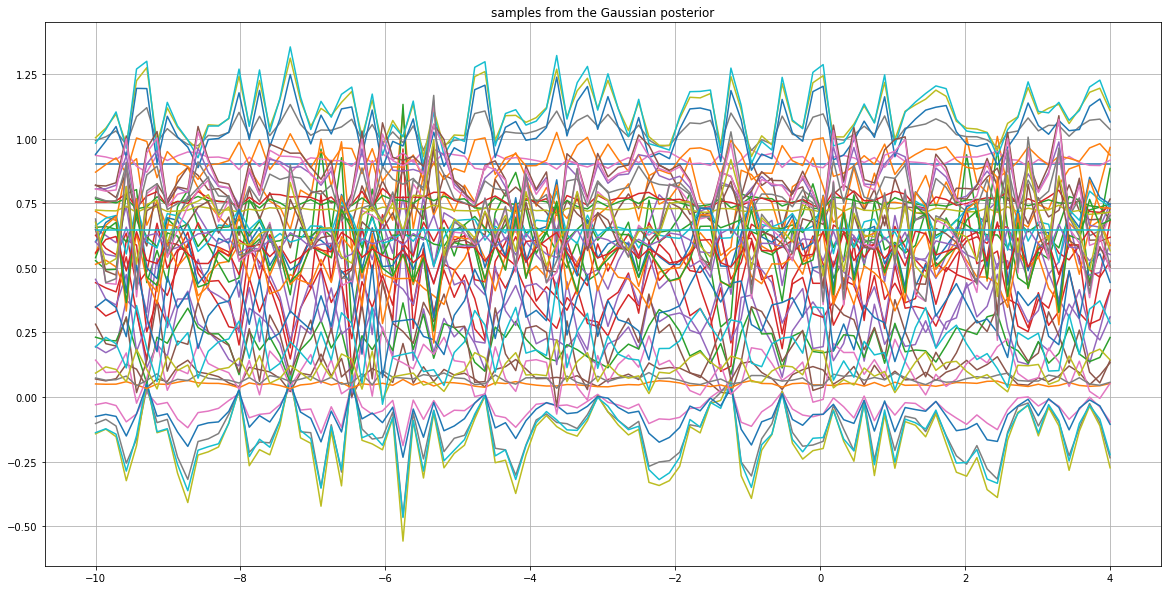

In [187]:
plt.figure(figsize=(20,10))
plt.grid()
plt.title('samples from the Gaussian posterior')
plt.plot(np.linspace(-10,4,100) , f)
#plt.plot(x_train, y_train, '*')
plt.show()

In [188]:
f.shape

(100, 50)

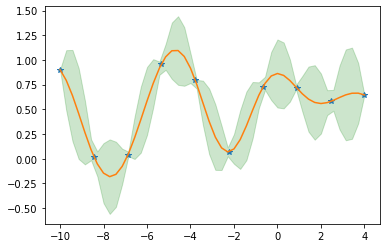

In [192]:
plt.plot(x_train, y_train, '*')
plt.plot(x_p, mean_function)
plt.fill_between(x_p.ravel(), mean_function-3*np.sqrt(np.diag(covariance_function)), mean_function+3*np.sqrt(np.diag(covariance_function)), color='g', alpha=.2)

In [190]:
covariance_function.shape

(50, 50)